<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink service demonstration: Cone Search

### Goal

The goal of this notebook is to demonstrate how to use Fink to match a local list of sources to LSST alerts.

For Rubin, Fink API is updated in real time, even during observation periods in Chile. 
Thus, it is possible to use the examples shown for quick decision making and inspection. 

### Environment set-up

To run this notebook, you need to import the following libraries (already installed in colab):

In [1]:
import requests
import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

APIURL = 'https://api.lsst.fink-portal.org'

### Case 1: cone search around one position and error

First set is to identify all the `objects` within your circle of interest

In [26]:
# Get the diaObjectId for the alert(s) within a circle on the sky
r0 = requests.post(
    '{}/api/v1/conesearch'.format(APIURL),
  
    json={
        "ra": "61.9648",
        "dec": "-48.713",
        "radius": "10"        # radius should be in arcsec
        }
)

The query above will return the last alert per objectId found within your search area.

The second step is to extract the `objectId` themselves and subsequently, the photometric data.

In [3]:
# extract the list of objectIds
mylist = [val["r:diaObjectId"] for val in r0.json()]

You can directly inspect these objects in the portal

In [5]:
for name in mylist:
    print('https://lsst.fink-portal.org/{}'.format(name))

https://lsst.fink-portal.org/313761043604045880
https://lsst.fink-portal.org/170028498820792325


In order to get full light curves for these two objects, you should query the `sources` endpoint

In [6]:
# get full lightcurves for all these alerts
r1 = requests.post(
  '{}/api/v1/sources'.format(APIURL),

  json={
    "diaObjectId":  ", ".join(map(str, mylist)),
      
    # choose which columns you want to transfer: https://lsst.fink-portal.org/schemas
    "columns": "r:diaObjectId,r:midpointMjdTai,r:psfFlux,r:psfFluxErr,r:band",
    "output-format": "json"
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r1.content))

You can now plot the resulting light curves for any of the given objectIds

In [7]:
# get only data for the first object in the list
mask = pdf['r:diaObjectId'] == mylist[0]
obj_lc = pdf[mask]

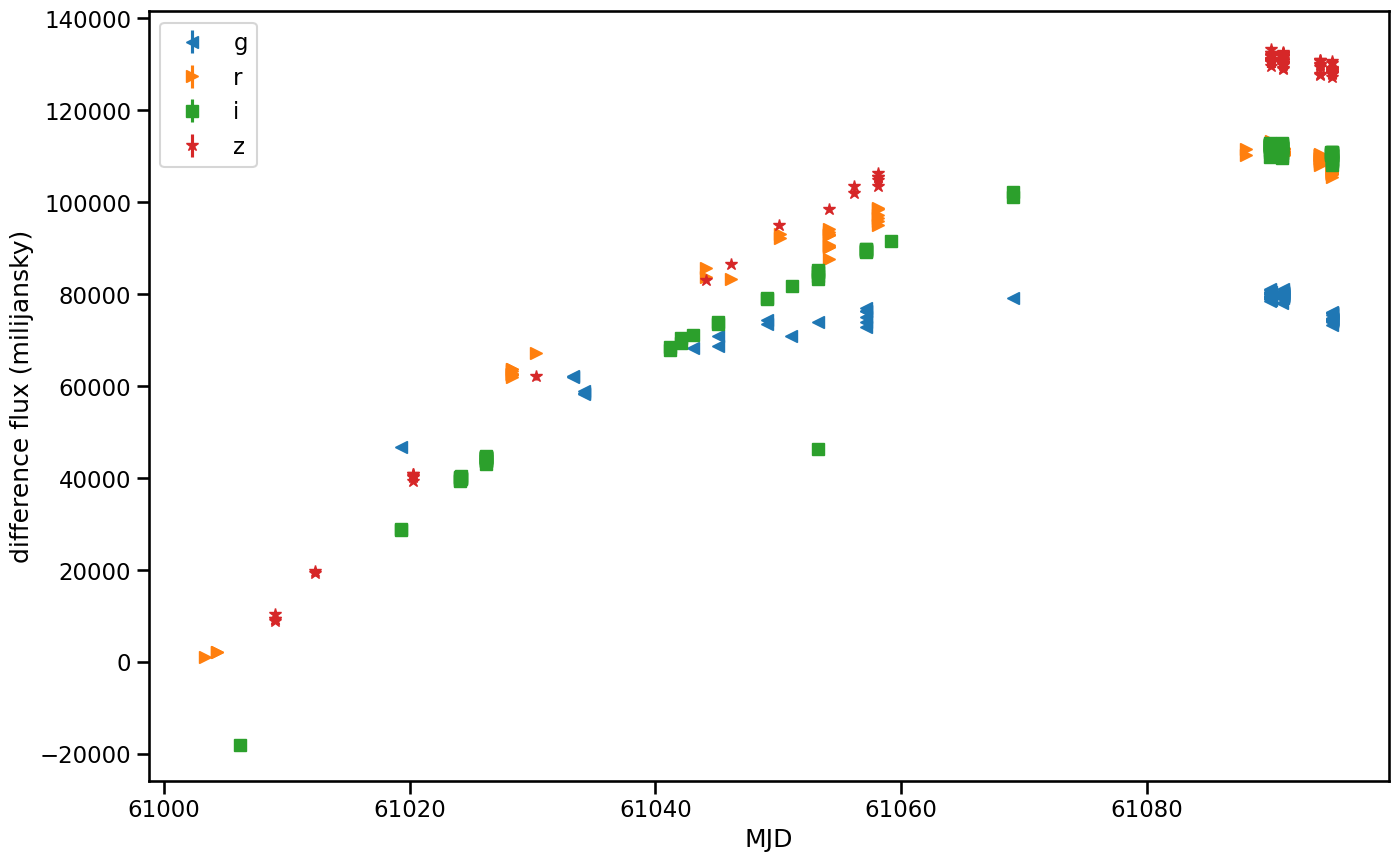

In [8]:
# all lsst bands
all_bands = ['u', 'g', 'r', 'i', 'z', 'y']
symbols = ['o', '<', '>', 's', '*', 'p']

# get unique filters
lc_bands = np.unique(obj_lc['r:band'])

plt.figure(figsize=(16,10))

for i in range(len(all_bands)):
    if all_bands[i] in lc_bands:
        flag = obj_lc['r:band'] == all_bands[i]        # identify one filter at a time
        
        mjd = obj_lc['r:midpointMjdTai'][flag]         # get observation days (MJD)
        flux = obj_lc['r:psfFlux'][flag]               # get difference flux
        fluxerr = obj_lc['r:psfFluxErr'][flag]         # get difference flux error

        plt.errorbar(mjd, flux, yerr=fluxerr, fmt=symbols[i], label=all_bands[i])

plt.xlabel('MJD')
plt.ylabel('difference flux (milijansky)')
plt.legend(loc='upper left')
plt.show()

### Case 2: cone search for a list of positions

In order to cross-match with an entire catalog, you can loop over your sources

In [9]:
# read your catalog
my_cat = pd.read_csv('cone_search_example.csv')

In [15]:
# check the size of your catalog
my_cat.shape

(25, 3)

In [13]:
store_objs = []

# launch a sequence of queries
for i in range(my_cat.shape[0]):
    
    r = requests.post(
        '{}/api/v1/conesearch'.format(APIURL),
  
        json={
            "ra": str(my_cat['ra'][i]),
            "dec": str(my_cat['dec'][i]),
            "radius": "1.5"                       # radius should be in arcsec
        }
    )

    pdf = pd.read_json(io.BytesIO(r.content))
    store_objs.append(pdf)

data_all = pd.concat(store_objs, ignore_index=True)

In [24]:
#check how many objects were found
data_all.shape

(41, 186)

Note that each one of the searches identifies the last alert of each object, but the same alert can be associated to more than one source in your catalog.

In this example, we found 41 alerts, but the number of objects is different.

In [27]:
obj_ids = np.unique(data_all['r:diaObjectId'])
obj_ids.shape

(11,)

You can now extract the `objectId` for every source which got cross-matched and check them at the Fink portal

In [29]:
for name in obj_ids:
    print('https://lsst.fink-portal.org/{}'.format(name))

https://lsst.fink-portal.org/170028510695916335
https://lsst.fink-portal.org/170028510831181832
https://lsst.fink-portal.org/170028521943466017
https://lsst.fink-portal.org/170028527544959074
https://lsst.fink-portal.org/170032908006326285
https://lsst.fink-portal.org/313862203201028173
https://lsst.fink-portal.org/313871014369951753
https://lsst.fink-portal.org/313875416991924268
https://lsst.fink-portal.org/313998569677259171
https://lsst.fink-portal.org/314007379158499424
https://lsst.fink-portal.org/314007379963805782


> **⚠️ Warning**
> This service should not be used for catalogs containing more than a few thousand entries
> The xmatch service for larger samples will be made available shortly